### First step:
The first step is undoubtedly to read the data in xslx format and convert them to csv in order to be able to analyse them via pandas. In this first cell, certain functions are also defined which will be useful later on:
- <code>force_to_numeric</code>: this function has the task of converting all instances of values in the selected columns into numeric values, this function was developed to deal with the problem resulting from the fact that in some datasets the datatype of individual instances is sometimes not numeric (probably due to NaN values).
- knn_impute: this function has a dual purpose, that of calculating the ideal number of neighbours and then using this number as the value for imputing missing data into the dataframes resulting from the merge. This algorithm proposes missing values by calculating them according to a learning model that produces 'plausible' data
- column_remove: This function was developed with the sole purpose of limiting and thus equalising all datasets by only examining columns referring to data from 2018 onwards.
- generate_overall_trend_correlation: This function aims to calculate the overall correlation of a dataset based on the difference of individual values taken and compared year by year.
- generate_yearly_correlations: This function has a similar purpose to the one just discussed, it generates correlations between the absolute values of each instance taken individually year by year.

In [261]:
import openpyxl
import csv 
from sklearn.impute import KNNImputer
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
import warnings
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
#pulzia dati e creazione file csv

def force_to_numeric(dataframe1, dataframe2, dataframe3):
    cols = ['2023', '2022', '2021', '2020', '2019', '2018']
    for col in cols:
        try:
            dataframe1[col] = pd.to_numeric(dataframe1[col], errors='coerce')
        except KeyError:
            pass  
        try:
            dataframe2[col] = pd.to_numeric(dataframe2[col], errors='coerce')
        except KeyError:
            pass
        try:
            dataframe3[col] = pd.to_numeric(dataframe3[col], errors='coerce')
        except KeyError:
            pass
    return dataframe1, dataframe2, dataframe3


def knn_impute(dataframe):
    numeric_data = dataframe.select_dtypes(include=[np.number])
    cv_scores = []
    for k in range(1, 51):
        imputer = KNNImputer(n_neighbors=k)
        scores = cross_val_score(imputer, numeric_data, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(scores.mean())
    optimal_k = cv_scores.index(max(cv_scores)) + 1
    imputer = KNNImputer(n_neighbors=optimal_k)
    imputed_data = imputer.fit_transform(numeric_data)
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns)
    dataframe[numeric_data.columns] = imputed_df
    return dataframe, optimal_k


def column_remove(dataframe1, dataframe2, dataframe3):
    dataframe1 = dataframe1.iloc[:, :7]
    dataframe2 = dataframe2.iloc[:, :7]
    dataframe3 = dataframe3.iloc[:, :7]
    return dataframe1, dataframe2, dataframe3

def generate_overall_trend_correlation(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame) -> None:
    """
    Calculates the correlation between the differences in values for each column of three input dataframes and prints the results.

    Args:
        df1 (pd.DataFrame): The first input dataframe.
        df2 (pd.DataFrame): The second input dataframe.
        df3 (pd.DataFrame): The third input dataframe.

    Returns:
        None: The function only prints the correlation matrices for each column.
    """
    common_columns = df1.columns.intersection(df2.columns).intersection(df3.columns)

    for column in common_columns:
        diff_df1 = df1[column].diff().dropna()
        diff_df2 = df2[column].diff().dropna()
        diff_df3 = df3[column].diff().dropna()
        merged_diff_df = pd.concat([diff_df1, diff_df2, diff_df3], axis=1)
        correlation = merged_diff_df.corr(method="spearman")
        print(f'Correlation in trend for {column}:\n', correlation)
        
def generate_yearly_correlations(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame) -> None:
    """
    Calculates the correlation between columns of three input dataframes and prints the results.

    Args:
        df1 (pd.DataFrame): The first input dataframe.
        df2 (pd.DataFrame): The second input dataframe.
        df3 (pd.DataFrame): The third input dataframe.

    Returns:
        None: The function only prints the correlation matrices for each common column.
    """
    common_columns = df1.columns.intersection(df2.columns).intersection(df3.columns)
    
    for column in common_columns:
        merged_df = pd.concat([df1[column], df2[column], df3[column]], axis=1)
        correlation = merged_df.corr(method="spearman")
        print(f'Correlation for {column}:\n', correlation)


#education science and research
df_total_research_fundings = pd.read_excel("../data/education_science_research/total_research_funding.xlsx", skiprows=18)
df_men_research_fundings = pd.read_excel("../data/education_science_research/men_research_funding.xlsx", skiprows=18)
df_women_research_fundings = pd.read_excel("../data/education_science_research/women_research_funding.xlsx", skiprows=18)
df_total_research_fundings.to_csv("../data/education_science_research/total_research_funding.csv", index=False)
df_men_research_fundings.to_csv("../data/education_science_research/men_research_funding.csv", index=False)
df_women_research_fundings.to_csv("../data/education_science_research/women_research_funding.csv", index=False)


#environment and climate change
df_total_political_executives = pd.read_excel("../data/environment_climate_change/total_political_executives_climate.xlsx", skiprows=18)
df_men_political_executives = pd.read_excel("../data/environment_climate_change/men_political_executives_climate.xlsx", skiprows=18)
df_women_political_executives = pd.read_excel("../data/environment_climate_change/women_political_executives_climate.xlsx", skiprows=18)
df_total_political_executives.to_csv("../data/environment_climate_change/total_political_executives_climate.csv", index=False)
df_men_political_executives.to_csv("../data/environment_climate_change/men_political_executives_climate.csv", index=False)
df_women_political_executives.to_csv("../data/environment_climate_change/women_political_executives_climate.csv", index=False)


#major political party leaders
df_total_political_parties = pd.read_excel("../data/major_political_party_leaders/total_political_parties.xlsx", skiprows=18)
df_men_political_parties = pd.read_excel("../data/major_political_party_leaders/men_political_parties.xlsx", skiprows=18)
df_women_political_parties = pd.read_excel("../data/major_political_party_leaders/women_political_parties.xlsx", skiprows=18)
df_total_political_parties.to_csv("../data/major_political_party_leaders/total_political_parties.csv", index=False)
df_men_political_parties.to_csv("../data/major_political_party_leaders/men_political_parties.csv", index=False)
df_women_political_parties.to_csv("../data/major_political_party_leaders/women_political_parties.csv", index=False)



#public EU administrations
df_public_adm_total = pd.read_excel("../data/European_public_admin/european_agencies_total.xlsx", skiprows=18)
df_public_adm_men = pd.read_excel("../data/European_public_admin/european_agencies_men.xlsx", skiprows=18)
df_public_adm_women = pd.read_excel("../data/European_public_admin/european_agencies_women.xlsx", skiprows=18)
df_public_adm_total.to_csv("../data/European_public_admin/european_agencies_total.csv", index=False)
df_public_adm_men.to_csv("../data/European_public_admin/european_agencies_men.csv", index=False)
df_public_adm_women.to_csv("../data/European_public_admin/european_agencies_women.csv", index=False)


#european courts
df_total_european_court = pd.read_excel("../data/european_courts/total_judges_european_court.xlsx", skiprows=18)
df_men_european_court = pd.read_excel("../data/european_courts/men_judges_european_court.xlsx", skiprows=18)
df_women_european_court = pd.read_excel("../data/european_courts/women_judges_european_court.xlsx", skiprows=18)
df_total_european_court.to_csv("../data/european_courts/total_judges_european_court.csv", index=False)
df_men_european_court.to_csv("../data/european_courts/men_judges_european_court.csv", index=False)
df_women_european_court.to_csv("../data/european_courts/women_judges_european_court.csv", index=False)


#european finance
df_european_financial_institutions_total = pd.read_excel("../data/European_finance/european_financial_institutions_total.xlsx", skiprows=18)
df_european_financial_institutions_men = pd.read_excel("../data/European_finance/european_financial_institutions_men.xlsx", skiprows=18)
df_european_financial_institutions_women = pd.read_excel("../data/European_finance/european_financial_institutions_women.xlsx", skiprows=18)
df_european_financial_institutions_total.to_csv("../data/European_finance/european_financial_institutions_total.csv", index = False)
df_european_financial_institutions_men.to_csv("../data/European_finance/european_financial_institutions_men.csv", index= False)
df_european_financial_institutions_women.to_csv("../data/European_finance/european_financial_institutions_women.csv", index= False)

### First look at correlations of the dataframes

Using the two functions developed above we can start to look at the correlations: The first function looks at the correlation between the absolute values of the columns, while the second function looks at the correlation between the trends or changes in values over time for each column. The second function is useful when you are interested in understanding how the trends in values for common columns correlate between two dataframes.

In [262]:
# generate_overall_trend_correlation(df_women_research_fundings.iloc[:, 1:], df_women_political_executives.iloc[:, 1:], df_women_political_parties.iloc[:, 1:])
# generate_yearly_correlations(df_women_research_fundings.iloc[:, 1:], df_women_political_executives.iloc[:, 1:], df_women_political_parties.iloc[:, 1:])


### Merging all dataset that share the Geographic region column

In [263]:
#pol parties
#environments
#research
from sklearn.model_selection import cross_val_score

df_women_research_fundings = df_women_research_fundings.rename(columns={"Geographic region\Time": "Geographic region"})
df_women_political_executives = df_women_political_executives.rename(columns={"Geographic region\Time": "Geographic region"})
df_women_political_parties = df_women_political_parties.rename(columns={"Geographic region\Time": "Geographic region"})
df_women_research_fundings, df_women_political_executives, df_women_political_parties = column_remove(df_women_research_fundings, df_women_political_executives, df_women_political_parties)
df_women_research_fundings, df_women_political_executives, df_women_political_parties = force_to_numeric(df_women_research_fundings, df_women_political_executives, df_women_political_parties)

merged_df = pd.merge(df_women_political_parties, df_women_research_fundings, on="Geographic region")
merged_df_final = pd.merge(merged_df, df_women_political_executives, on="Geographic region") 

knn_impute(merged_df_final)
merged_df_final.head()


,Geographic region,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
0,Albania,0.0,0.0,1.0,1.0,1.0,1.0,5.0,5.0,4.0,4.0,4.0,4.0,6.0,1.0,2.0,3.0,2.0,2.0
1,Austria,2.0,2.0,2.0,2.0,2.0,0.0,18.0,19.0,18.0,13.0,12.0,12.0,1.0,2.0,1.0,1.0,1.0,0.0
2,Bosnia and Herzegovina,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0,1.0
3,Belgium,2.0,2.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,6.0,6.0,7.0,3.0,3.0,1.0,1.0,1.0,1.0
4,Bulgaria,1.0,1.0,1.0,1.0,1.0,1.0,6.0,6.0,5.0,5.0,4.0,4.0,3.0,4.0,3.0,3.0,2.0,2.0


To address missing values (NaN) in the dataset, we opted for an imputation technique employing machine learning models. Specifically, we utilized the K-Nearest Neighbors (KNN) algorithm to estimate missing values based on the values of the most similar observations.

### Spearman's correlation between variables in the merged dataset

In [264]:
# merged_df_final.corr().head()
spearman_corr = merged_df_final.corr(method='spearman')

spearman_corr
# spearman_corr = pd.DataFrame(spearman_corr)
# spearman_corr.hist()

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
2023_x,1.000000,0.954163,0.896823,0.870298,0.693090,0.645940,0.374805,0.435110,0.398453,0.404340,0.388177,0.393640,0.340778,0.414706,0.452449,0.409532,0.363895,0.381558
2022_x,0.954163,1.000000,0.876656,0.867667,0.713015,0.637088,0.344821,0.396863,0.384073,0.381874,0.358363,0.370709,0.350832,0.413849,0.461233,0.440512,0.404881,0.417298
2021_x,0.896823,0.876656,1.000000,0.949752,0.794230,0.682060,0.332182,0.398803,0.366289,0.367553,0.346971,0.343503,0.438973,0.459797,0.561961,0.564980,0.493357,0.482075
2020_x,0.870298,0.867667,0.949752,1.000000,0.897829,0.771646,0.348001,0.417555,0.399838,0.406135,0.387995,0.389077,0.451420,0.498432,0.594794,0.583894,0.529976,0.555317
2019_x,0.693090,0.713015,0.794230,0.897829,1.000000,0.841107,0.319698,0.373247,0.379114,0.356727,0.363855,0.345930,0.339161,0.444691,0.514041,0.492792,0.508522,0.533876
2018_x,0.645940,0.637088,0.682060,0.771646,0.841107,1.000000,0.342385,0.387831,0.384262,0.400150,0.381615,0.371559,0.428724,0.495044,0.565646,0.516925,0.538421,0.617942
2023_y,0.374805,0.344821,0.332182,0.348001,0.319698,0.342385,1.000000,0.979035,0.963170,0.931363,0.926211,0.933285,0.498863,0.424111,0.406089,0.307233,0.293033,0.375934
2022_y,0.435110,0.396863,0.398803,0.417555,0.373247,0.387831,0.979035,1.000000,0.985786,0.969630,0.961388,0.964621,0.506425,0.467312,0.466857,0.357033,0.338873,0.428079
2021_y,0.398453,0.384073,0.366289,0.399838,0.379114,0.384262,0.963170,0.985786,1.000000,0.981296,0.972068,0.974493,0.482819,0.472426,0.465531,0.352503,0.346932,0.439964
2020_y,0.404340,0.381874,0.367553,0.406135,0.356727,0.400150,0.931363,0.969630,0.981296,1.000000,0.987163,0.986867,0.523659,0.504371,0.506110,0.383337,0.371276,0.454735


### Heatmap of spearman's correlation for non linear variables

Se 2023_x, 2023_y e 2023 rappresentano il numero di donne in diversi ambiti nello stesso anno, allora la heatmap mostra come questi ambiti siano correlati tra loro nel tempo.

Correlazione tra gli stessi ambiti negli anni: Le celle con colori più caldi (come il rosso) lungo la diagonale indicano che c’è una forte correlazione positiva tra lo stesso ambito negli anni successivi. Questo suggerisce che se il numero di donne in un certo ambito aumenta o diminuisce in un anno, è probabile che segua un trend simile anche negli anni successivi.

Correlazione tra diversi ambiti nello stesso anno: Le celle che non sono sulla diagonale mostrano la correlazione tra diversi ambiti nello stesso anno. Ad esempio, la cella che incrocia 2023_x e 2023_y mostra la correlazione tra questi due ambiti nel 2023. Se il colore di questa cella è caldo, significa che se il numero di donne aumenta in un ambito (2023_x), è probabile che aumenti anche nell’altro ambito (2023_y), e viceversa.

Correlazione tra diversi ambiti negli anni: Le celle che non sono né sulla diagonale né nello stesso anno mostrano la correlazione tra diversi ambiti negli anni. Ad esempio, la cella che incrocia 2023_x e 2022_y mostra la correlazione tra l’ambito x nel 2023 e l’ambito y nel 2022. Se il colore di questa cella è freddo, significa che questi due ambiti non sono fortemente correlati tra loro nel tempo.

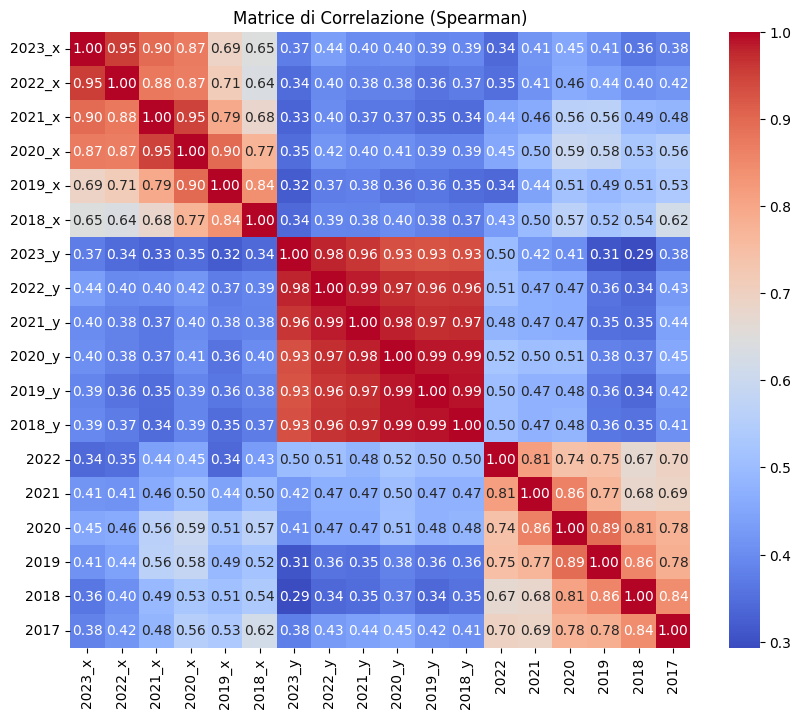

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione (Spearman)')
plt.show()

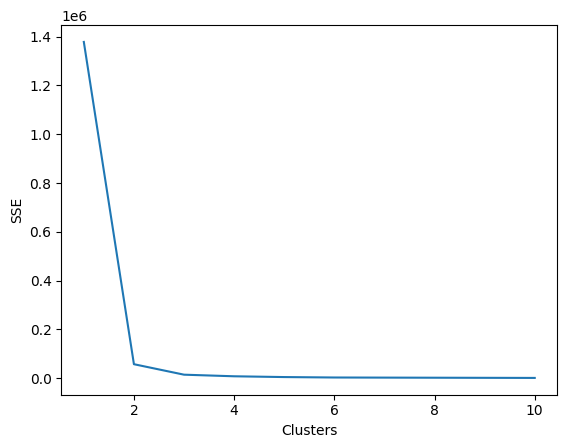

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import cluster
# cols = ['2023', '2022', '2021', '2020', '2019', '2018']
# df_public_adm_women[cols] = df_public_adm_women[cols].apply(pd.to_numeric, errors='coerce')
# df_women_research_fundings = df_women_research_fundings.dropna()
# merged_df_final = merged_df_final.fillna(merged_df_final.mean())
# df_women_research_fundings = df_women_research_fundings.reset_index(drop=True)
merged_df_final = merged_df_final.reset_index(drop=True)
# X = df_women_research_fundings.iloc[:,1:].values
X = merged_df_final.iloc[:,1:].values

# Apply elbow method to understand the number of cluster

wcss = []
for i in range(1,11):
    k_means = cluster.KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_) 

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [267]:
from sklearn.cluster import KMeans
import pandas as pd

# Supponiamo che 'df' sia il tuo DataFrame
# Elimina le righe con valori NaN
# merged_df_final = merged_df_final.fillna(merged_df_final.mean())


# Seleziona le colonne numeriche per l'analisi dei cluster
data = merged_df_final.select_dtypes(include=[np.number])

# Inizializza l'algoritmo KMeans con il numero desiderato di cluster
kmeans = KMeans(n_clusters=3)

# Adatta l'algoritmo ai tuoi dati
kmeans.fit(data)

# Ottieni le etichette dei cluster per ciascuna riga nel DataFrame
labels = kmeans.labels_

# Aggiungi le etichette dei cluster al DataFrame originale
merged_df_final['Cluster'] = labels
labels
cluster_means = merged_df_final.groupby('Cluster').mean()
cluster_means


,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
Cluster,,,,,,,,,,,,,,,,,,
0,2.000000,1.666667,2.166667,2.000000,1.666667,1.500000,52.666667,42.500000,43.666667,43.000000,42.500000,41.166667,4.000000,2.333333,2.666667,2.333333,1.666667,2.166667
1,44.000000,40.500000,42.500000,34.500000,26.000000,28.000000,382.000000,363.500000,351.000000,339.000000,331.000000,321.000000,49.500000,48.500000,38.500000,39.000000,31.000000,30.500000
2,1.529412,1.382353,1.352941,1.147059,1.029412,1.058824,7.970588,7.617647,6.941176,6.441176,6.411765,6.352941,1.852941,1.823529,1.470588,1.382353,1.205882,1.058824


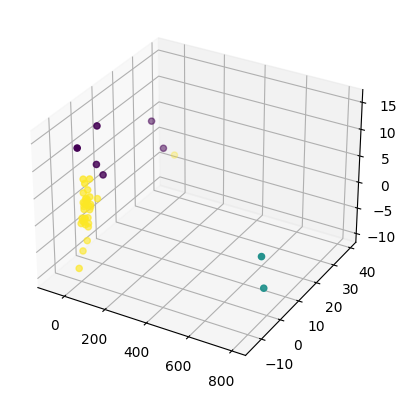

In [268]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Riduci la dimensionalità dei tuoi dati a 3 dimensioni utilizzando PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Crea una nuova figura
fig = plt.figure()

# Aggiungi un grafico 3D alla figura
ax = fig.add_subplot(111, projection='3d')

# Assegna a x, y, e z le tre componenti principali
x = reduced_data[:, 0]
y = reduced_data[:, 1]
z = reduced_data[:, 2]

# Crea un grafico a dispersione 3D utilizzando le etichette dei cluster per colorare i punti
scatter = ax.scatter(x, y, z, c=labels)

# Mostra il grafico
plt.show()


In [269]:
# Per ciascun cluster
for cluster in merged_df_final['Cluster'].unique():
    # Seleziona solo le righe per questo cluster
    cluster_data = merged_df_final[merged_df_final['Cluster'] == cluster]
    
    # Ottieni i nomi delle agenzie in questo cluster
    agencies = cluster_data['Geographic region']
    
    # Stampa le agenzie
    print(f'Cluster {cluster}:')
    print(agencies.head())


Cluster 2:
0                   Albania
1                   Austria
2    Bosnia and Herzegovina
3                   Belgium
4                  Bulgaria
Name: Geographic region, dtype: object
Cluster 0:
7                                               Germany
20    Instrument for Pre-accession Assistance (IPA) ...
22                                                Italy
27                                           Montenegro
34                                              Romania
Name: Geographic region, dtype: object
Cluster 1:
13    European Union - 27 countries (from 2020)
14    European Union - 28 countries (1993-2020)
Name: Geographic region, dtype: object


I cluster ottenuti rappresentano gruppi di agenzie che hanno modelli simili nel numero di donne in ruoli influenti nel corso degli anni. Le agenzie nello stesso cluster hanno modelli di cambiamento nel tempo più simili tra loro rispetto alle agenzie in cluster diversi.

Il criterio con cui sono stati clusterizzati i dati è basato sulla distanza euclidea tra i punti in uno spazio multidimensionale, dove ogni dimensione rappresenta un anno. L’algoritmo KMeans cerca di minimizzare la varianza all’interno di ciascun cluster, che è la somma delle distanze al quadrato tra ciascun punto e il centroide del suo cluster.

### Mean of the cluster values and time visualization of cluster's pattern

In [270]:
cluster_means = merged_df_final.groupby('Cluster').mean()
cluster_means

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2022,2021,2020,2019,2018,2017
Cluster,,,,,,,,,,,,,,,,,,
0,2.000000,1.666667,2.166667,2.000000,1.666667,1.500000,52.666667,42.500000,43.666667,43.000000,42.500000,41.166667,4.000000,2.333333,2.666667,2.333333,1.666667,2.166667
1,44.000000,40.500000,42.500000,34.500000,26.000000,28.000000,382.000000,363.500000,351.000000,339.000000,331.000000,321.000000,49.500000,48.500000,38.500000,39.000000,31.000000,30.500000
2,1.529412,1.382353,1.352941,1.147059,1.029412,1.058824,7.970588,7.617647,6.941176,6.441176,6.411765,6.352941,1.852941,1.823529,1.470588,1.382353,1.205882,1.058824


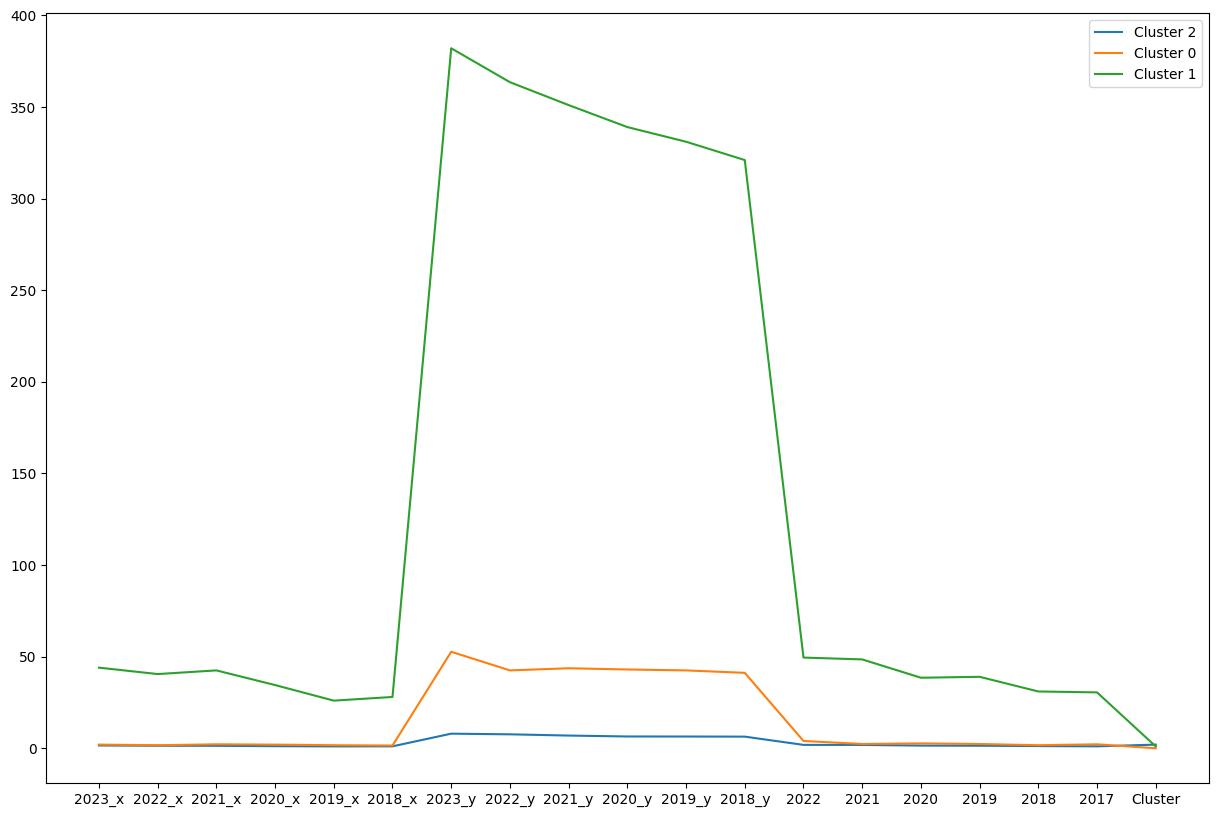

In [271]:
plt.figure(figsize=(15, 10))

# Crea un grafico lineare per ciascun cluster
for cluster in merged_df_final['Cluster'].unique():
    # Seleziona solo le righe per questo cluster
    cluster_data = merged_df_final[merged_df_final['Cluster'] == cluster]
    
    # Calcola la media del numero di donne in ruoli influenti per ciascun anno
    means = cluster_data.mean()
    
    # Crea un grafico lineare delle medie
    plt.plot(means.index, means.values, label=f'Cluster {cluster}')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.show()


### Dimostrazione della non linearità delle relazioni

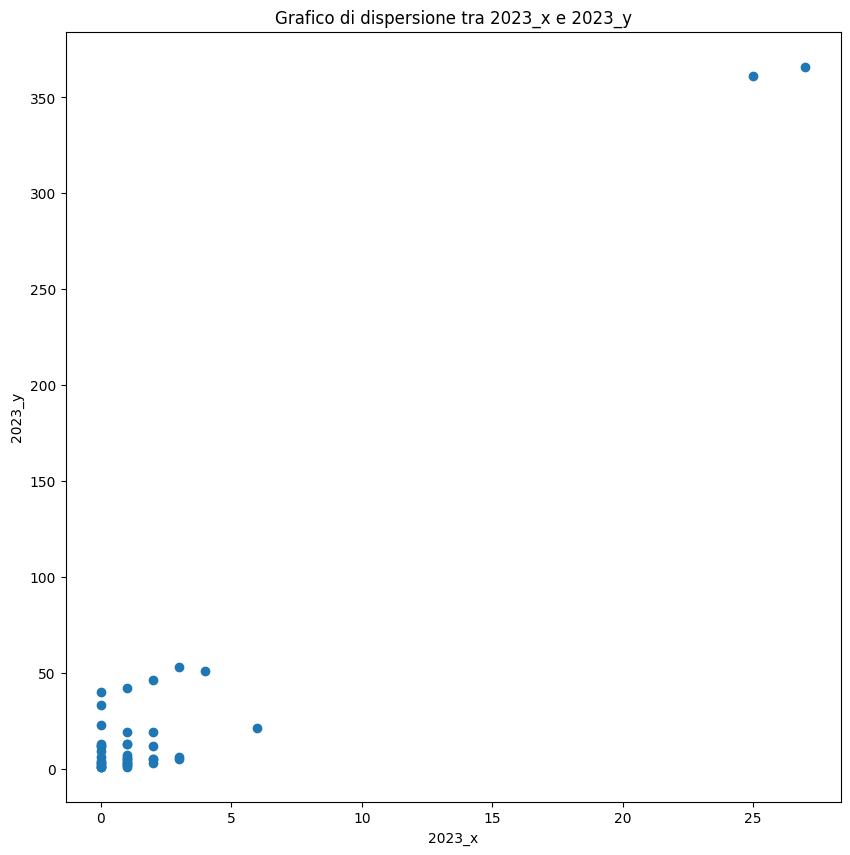

In [272]:
import matplotlib.pyplot as plt

# Creazione del grafico di dispersione
plt.figure(figsize=(10, 10))
plt.scatter(merged_df_final['2019_x'], merged_df_final['2022_y'])

# Aggiunta dei titoli agli assi e al grafico
plt.title('Grafico di dispersione tra 2023_x e 2023_y')
plt.xlabel('2023_x')
plt.ylabel('2023_y')

# Visualizzazione del grafico
plt.show()


### Merging all datasets that share the Time column (renamed "Agency" column)

In [273]:
#public administration
#european court
#european finance

df_public_adm_women = df_public_adm_women.rename(columns={"Time":"Agency"})
df_women_european_court = df_women_european_court.rename(columns={"Time":"Agency"})
df_european_financial_institutions_women = df_european_financial_institutions_women.rename(columns={"Time":"Agency"})


df_public_adm_women, df_women_european_court, df_european_financial_institutions_women = column_remove(df_public_adm_women, df_women_european_court, df_european_financial_institutions_women)
df_public_adm_women, df_women_european_court, df_european_financial_institutions_women = force_to_numeric(df_public_adm_women, df_women_european_court, df_european_financial_institutions_women)

merged_df2 = pd.merge(df_public_adm_women, df_women_european_court, on="Agency", how='outer')
merged_df_final2 = pd.merge(merged_df2, df_european_financial_institutions_women, on="Agency", how="outer") #nella manipolazione dati abbiamo deciso di introdurre lo 0 al posto di NaN

knn_impute(merged_df_final2)
merged_df_final2.head()


,Agency,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
0,Entity\Sex,24.5,23.435897,22.923077,23.692308,22.789474,22.842105,16.25,14.75,15.0,14.0,11.75,11.75,6.0,6.0,5.0,4.0,3.5,4.5
1,Total,490.0,457.000000,447.000000,462.000000,433.000000,434.000000,16.25,14.75,15.0,14.0,11.75,11.75,12.0,12.0,10.0,8.0,7.0,9.0
2,Agency for the Cooperation of Energy Regulator...,8.0,7.000000,7.000000,6.000000,8.000000,7.000000,16.25,14.75,15.0,14.0,11.75,11.75,12.0,12.0,10.0,8.0,7.0,9.0
3,Body of European Regulators for Electronic Com...,7.0,9.000000,8.000000,6.000000,5.000000,4.000000,16.25,14.75,15.0,14.0,11.75,11.75,12.0,12.0,10.0,8.0,7.0,9.0
4,Community Plant Variety Office (CPVO),10.0,12.000000,13.000000,12.000000,11.000000,13.000000,16.25,14.75,15.0,14.0,11.75,11.75,12.0,12.0,10.0,8.0,7.0,9.0


In [274]:
spearman_corr2 = merged_df_final2.corr(method='spearman')

spearman_corr2

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
2023_x,1.000000,0.936042,0.923287,0.911242,0.896470,0.910029,0.137183,0.137183,0.137195,0.137183,0.000000,0.000000,-0.627529,-0.627550,-0.627550,-0.637330,-0.637330,-0.627529
2022_x,0.936042,1.000000,0.978044,0.956125,0.931659,0.948864,0.128403,0.128403,0.128414,0.128403,0.000000,0.000000,-0.601450,-0.601470,-0.601470,-0.612235,-0.612235,-0.601450
2021_x,0.923287,0.978044,1.000000,0.960763,0.951662,0.958706,0.137218,0.137218,0.137230,0.137218,0.000000,0.000000,-0.627689,-0.627709,-0.627709,-0.637493,-0.637493,-0.627689
2020_x,0.911242,0.956125,0.960763,1.000000,0.978825,0.967320,0.128417,0.128417,0.128428,0.128417,0.000000,0.000000,-0.601516,-0.601536,-0.601536,-0.612302,-0.612302,-0.601516
2019_x,0.896470,0.931659,0.951662,0.978825,1.000000,0.972666,0.128361,0.128361,0.128372,0.128361,0.000000,0.000000,-0.601253,-0.601273,-0.601273,-0.612034,-0.612034,-0.601253
2018_x,0.910029,0.948864,0.958706,0.967320,0.972666,1.000000,0.128356,0.128356,0.128367,0.128356,0.000000,0.000000,-0.601232,-0.601251,-0.601251,-0.612012,-0.612012,-0.601232
2023_y,0.137183,0.128403,0.137218,0.128417,0.128361,0.128356,1.000000,1.000000,0.999911,0.999644,0.509609,0.508897,-0.243869,-0.243877,-0.243877,-0.231981,-0.231981,-0.243869
2022_y,0.137183,0.128403,0.137218,0.128417,0.128361,0.128356,1.000000,1.000000,0.999911,0.999644,0.509609,0.508897,-0.243869,-0.243877,-0.243877,-0.231981,-0.231981,-0.243869
2021_y,0.137195,0.128414,0.137230,0.128428,0.128372,0.128367,0.999911,0.999911,1.000000,0.999911,0.518907,0.518374,-0.243891,-0.243899,-0.243899,-0.232001,-0.232001,-0.243891
2020_y,0.137183,0.128403,0.137218,0.128417,0.128361,0.128356,0.999644,0.999644,0.999911,1.000000,0.528114,0.527758,-0.243869,-0.243877,-0.243877,-0.231981,-0.231981,-0.243869


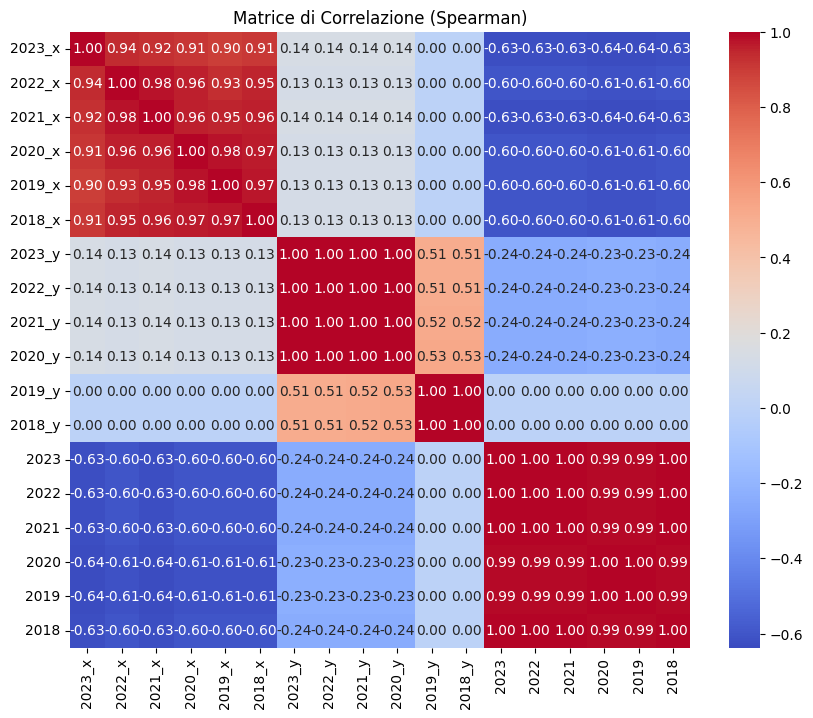

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione (Spearman)')
plt.show()

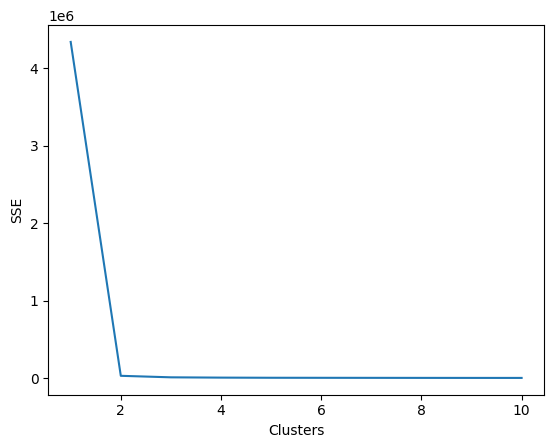

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import cluster
# cols = ['2023', '2022', '2021', '2020', '2019', '2018']
# df_public_adm_women[cols] = df_public_adm_women[cols].apply(pd.to_numeric, errors='coerce')
# df_women_research_fundings = df_women_research_fundings.dropna()
# merged_df_final2 = merged_df_final2.fillna(merged_df_final2.mean())
# df_women_research_fundings = df_women_research_fundings.reset_index(drop=True)
# merged_df_final2 = merged_df_final2.reset_index(drop=True)
# X = df_women_research_fundings.iloc[:,1:].values
X = merged_df_final2.iloc[:,1:].values

# Apply elbow method to understand the number of cluster

wcss = []
for i in range(1,11):
    k_means = cluster.KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X)
    wcss.append(k_means.inertia_) 

plt.plot(np.arange(1,11),wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [277]:
from sklearn.cluster import KMeans
import pandas as pd

# Supponiamo che 'df' sia il tuo DataFrame
# Elimina le righe con valori NaN
merged_df_final2 = merged_df_final2.fillna(merged_df_final2.mean())


# Seleziona le colonne numeriche per l'analisi dei cluster
data = merged_df_final2.select_dtypes(include=[np.number])

# Inizializza l'algoritmo KMeans con il numero desiderato di cluster
kmeans = KMeans(n_clusters=2)

# Adatta l'algoritmo ai tuoi dati
kmeans.fit(data)

# Ottieni le etichette dei cluster per ciascuna riga nel DataFrame
labels = kmeans.labels_

# Aggiungi le etichette dei cluster al DataFrame originale
merged_df_final2['Cluster'] = labels
labels
cluster_means = merged_df_final2.groupby('Cluster').mean()
cluster_means


,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
Cluster,,,,,,,,,,,,,,,,,,
0,14.862745,14.183509,13.906486,14.19457,13.625387,13.772962,16.25,14.75,15.0,14.0,11.75,11.75,10.823529,10.823529,9.019608,7.215686,6.313725,8.117647
1,490.000000,457.000000,447.000000,462.00000,433.000000,434.000000,16.25,14.75,15.0,14.0,11.75,11.75,6.000000,6.000000,5.000000,4.000000,3.500000,4.500000


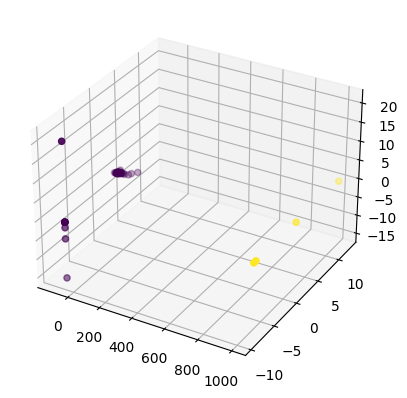

In [278]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Riduci la dimensionalità dei tuoi dati a 3 dimensioni utilizzando PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Crea una nuova figura
fig = plt.figure()

# Aggiungi un grafico 3D alla figura
ax = fig.add_subplot(111, projection='3d')

# Assegna a x, y, e z le tre componenti principali
x = reduced_data[:, 0]
y = reduced_data[:, 1]
z = reduced_data[:, 2]

# Crea un grafico a dispersione 3D utilizzando le etichette dei cluster per colorare i punti
scatter = ax.scatter(x, y, z, c=labels)

# Mostra il grafico
plt.show()


La riduzione della dimensionalità, come quella effettuata dalla PCA (Principal Component Analysis), è spesso necessaria per diversi motivi:

- Visualizzazione dei dati: È difficile visualizzare dati ad alta dimensionalità. Ridurre i dati a 2 o 3 dimensioni può aiutare a visualizzare i dati e a capire meglio le relazioni tra le variabili.

- Riduzione del rumore: La riduzione della dimensionalità può aiutare a rimuovere il “rumore” nei dati, mantenendo solo le caratteristiche più importanti.

- Efficienza computazionale: Modelli di apprendimento automatico possono essere più efficienti con meno variabili di input. Ridurre la dimensionalità dei dati può accelerare il tempo di addestramento del modello e richiedere meno risorse di memoria.

- Evitare la maledizione della dimensionalità: Con un numero elevato di dimensioni, i dati diventano molto sparsi. Questo può rendere difficile per alcuni algoritmi di apprendimento automatico trovare strutture significative nei dati.

- Ridurre la multicollinearità: In presenza di variabili altamente correlate, la riduzione della dimensionalità può aiutare a creare nuove variabili indipendenti, che possono migliorare le prestazioni di alcuni modelli di apprendimento automatico.

In [279]:
# Per ciascun cluster
for cluster in merged_df_final2['Cluster'].unique():
    # Seleziona solo le righe per questo cluster
    cluster_data = merged_df_final2[merged_df_final2['Cluster'] == cluster]
    
    # Ottieni i nomi delle agenzie in questo cluster
    agencies = cluster_data['Agency']
    
    # Stampa le agenzie
    print(f'Cluster {cluster}:')
    print(agencies.head())


Cluster 0:
0                                           Entity\Sex
2    Agency for the Cooperation of Energy Regulator...
3    Body of European Regulators for Electronic Com...
4                Community Plant Variety Office (CPVO)
5                          Euratom Supply Agency (ESA)
Name: Agency, dtype: object
Cluster 1:
1                        Total
52       European Central Bank
53    European Investment Bank
54    European Investment Fund
Name: Agency, dtype: object


Le componenti principali sono nuove variabili che vengono create come combinazioni delle tue variabili originali. Queste nuove variabili sono create in modo tale da catturare la maggior parte delle informazioni possibili dai tuoi dati.

Le variabili originali sono il numero di donne in ruoli influenti per ciascun anno e per ciascuna categoria (2023_x, 2022_x, 2021_x, ecc.). La PCA crea nuove variabili (le componenti principali) che sono combinazioni di queste variabili originali.

Ad esempio, la prima componente principale potrebbe essere 0.3 * 2023_x + 0.4 * 2022_x - 0.2 * 2021_x + .... Questa nuova variabile è creata in modo tale da catturare la maggior parte della varianza (la variazione) nei tuoi dati.

Nel tuo grafico 3D, ogni agenzia è rappresentata da un punto, e la posizione di quel punto lungo l’asse X è determinata dal valore della prima componente principale per quell’agenzia. Allo stesso modo, la posizione lungo l’asse Y è determinata dalla seconda componente principale, e la posizione lungo l’asse Z è determinata dalla terza componente principale

### Mean of the cluster values and time visualization of cluster's pattern

In [280]:
cluster_means = merged_df_final2.groupby('Cluster').mean()
cluster_means

,2023_x,2022_x,2021_x,2020_x,2019_x,2018_x,2023_y,2022_y,2021_y,2020_y,2019_y,2018_y,2023,2022,2021,2020,2019,2018
Cluster,,,,,,,,,,,,,,,,,,
0,14.862745,14.183509,13.906486,14.19457,13.625387,13.772962,16.25,14.75,15.0,14.0,11.75,11.75,10.823529,10.823529,9.019608,7.215686,6.313725,8.117647
1,490.000000,457.000000,447.000000,462.00000,433.000000,434.000000,16.25,14.75,15.0,14.0,11.75,11.75,6.000000,6.000000,5.000000,4.000000,3.500000,4.500000


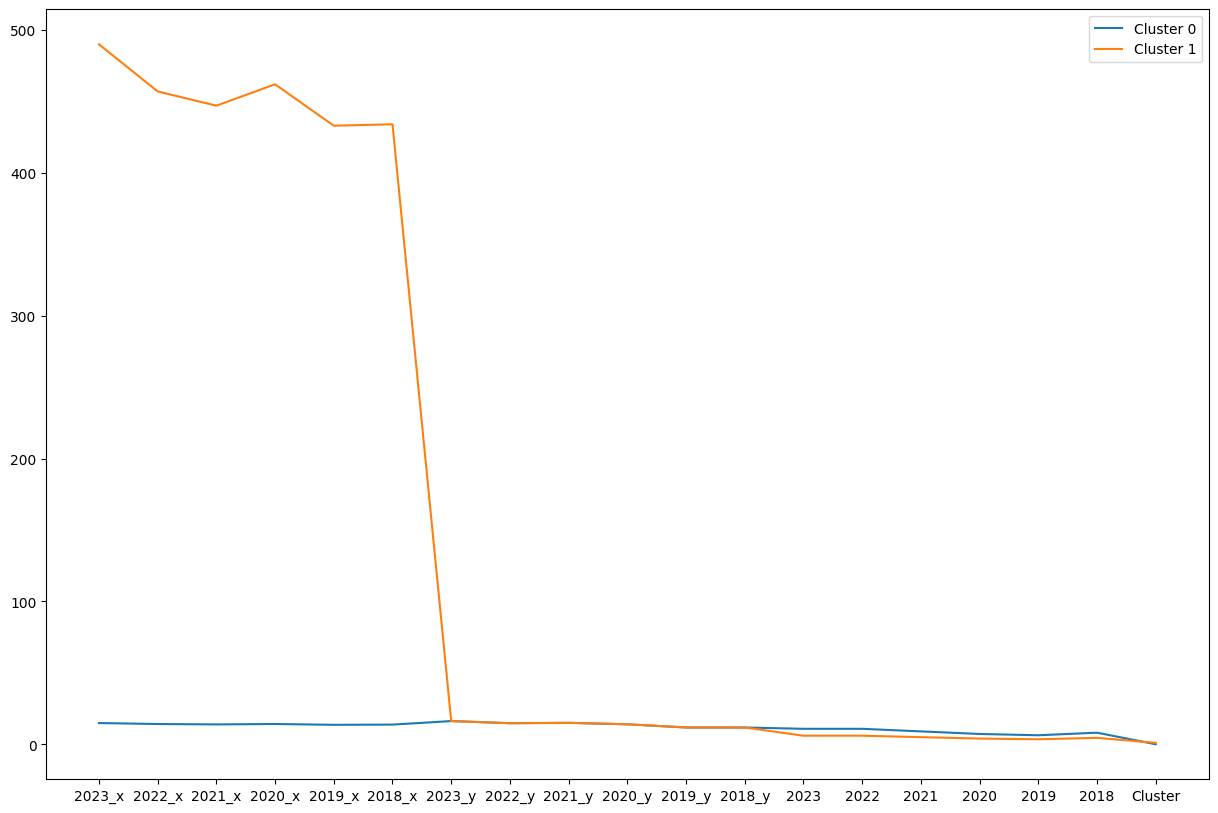

In [281]:
plt.figure(figsize=(15, 10))

# Crea un grafico lineare per ciascun cluster
for cluster in merged_df_final2['Cluster'].unique():
    # Seleziona solo le righe per questo cluster
    cluster_data = merged_df_final2[merged_df_final2['Cluster'] == cluster]
    
    # Calcola la media del numero di donne in ruoli influenti per ciascun anno
    means = cluster_data.mean()
    
    # Crea un grafico lineare delle medie
    plt.plot(means.index, means.values, label=f'Cluster {cluster}')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.show()


As it is possible to see in the graph data imposition using the averages of the dataset to fill the NaN values produces a pretty similar path for every cluster from a certain point in the graph. As it may not reflect the true situation of the women's position in different agencies over the years it still offers a good view of the path of the different cluster at least for the first variable (dataset)